In [2]:
import random
from collections import defaultdict, deque
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

WORDS_PATH = 'word.txt'
GRAPH_PATH = 'wordsdetail_graph.pkl'

In [3]:
def load_words(path):
    if not path:
        path = WORDS_PATH
    with open(path) as f:
        res = f.readlines()

    words = []
    for line in res:
        for word in line.split(','):
            word = word.strip().replace('"', '')
            if len(word) != 4:
                continue
            words.append(word)
    # remove '' from words
    words = [word for word in words if word != '']
    return words

In [5]:
# Step 1: Load the Word List
# For testing purposes, let's use a small word list.
words = load_words('scrabble_words.txt')

# Function to check if two words can be rearranged to form each other
def can_rearrange(word1, word2):
    return sorted(word1) == sorted(word2)

# Function to check if two words differ by only one letter
def one_letter_diff(word1, word2):
    if len(word1) != len(word2):
        return False
    diff_count = sum(1 for a, b in zip(word1, word2) if a != b)
    return diff_count == 1

def get_graph(words):
    # Build the word graph
    graph = defaultdict(list)
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i != j and (one_letter_diff(word1, word2) or can_rearrange(word1, word2)):
                graph[word1].append(word2)
    return graph

graph = get_graph(words)

KeyboardInterrupt: 

In [25]:
with open("word_graph.pkl", "wb") as file:
    pickle.dump(graph, file)

In [4]:
# load graph
def load_graph(path):
    if not path:
        path = GRAPH_PATH
    with open(path, "rb") as file:
        graph = pickle.load(file)
    return graph
graph = load_graph(GRAPH_PATH)


In [30]:
# how many components in the graph
def get_components(graph):
    visited = set()
    components = []
    for word in graph:
        if word not in visited:
            component = set()
            queue = deque([word])
            while queue:
                word = queue.popleft()
                if word not in visited:
                    visited.add(word)
                    component.add(word)
                    queue.extend(graph[word])
            components.append(component)
    return components
components = get_components(graph)
print('Number of components: {}'.format(len(components)))
for c in components:
    print(len(c))

for c in components[1:]:
    print(c)


Number of components: 3
5603
3
2
{'PTUI', 'ETUI', 'PFUI'}
{'ONYX', 'ORYX'}


In [6]:
def find_shortest_path(graph, start, end):
    """
    Find the shortest path between start and end words using BFS.
    """
    visited = set()
    queue = deque([(start, [start])])  # Each element in the queue is a tuple (current_word, path_so_far)

    while queue:
        current_word, path = queue.popleft()

        # If the current word is the end word, we've found a path
        if current_word == end:
            return path

        # Mark the current word as visited
        visited.add(current_word)

        # Add all neighboring words to the queue, if they haven't been visited yet
        for neighbor in graph[current_word]:
            if neighbor not in visited:
                queue.append((neighbor, path + [neighbor]))

    # If we reach here, it means there's no path from start to end
    return None

# Test the function
start_word = "aide"
end_word = "soda"
path = find_shortest_path(graph, start_word, end_word)
path

['aide', 'ride', 'rode', 'code', 'coda', 'soda']

In [79]:
def game_sequence():
    # Introduction
    print("Welcome to the 4-Letter Word Path Game!")
    print("Your goal is to change the starting word to the ending word, one letter at a time, forming valid words along the way.")
    print("You can also rearrange the letters to form a new word. Let's begin!")
    print("="*50)
    
    words = load_words('scrabble_words.txt')
    start_time = time.time()
    print('loading graph...')
    graph = load_graph(GRAPH_PATH)
    print('graph loaded in {} seconds'.format(time.time() - start_time))

    # Randomly select start and end words
    start_word = random.choice(words)
    end_word = random.choice(words)
    while start_word == end_word:
        end_word = random.choice(words)

    history = [start_word]
    score = 0

    print(f"Starting word: {start_word}")
    print(f"Target word: {end_word}")
    print("="*50)

    while True:
        next_word = input("Enter the next word in the sequence: ").upper().strip()
        if next_word in ('ESCAPE', 'ENTER'):
            print("Game ended.")
            optimal_path = find_shortest_path(graph, start_word, end_word)
            print(f"Optimal Path: {' -> '.join(optimal_path)}")
            print(f"Optimal Score: {len(optimal_path)-1}")
            break

        # Check if the word is valid
        if next_word in graph[history[-1]]:
            history.append(next_word)
            score += 1
        else:
            print("Invalid transition. Try again.")
            continue

        # Display history, score, and target word
        print("\nWord History:")
        print(" -> ".join(history))
        print(f"\nCumulative Score: {score}")
        print(f"Target Word: {end_word}\n")
        print("="*50)

        # Check for game completion
        if next_word == end_word:
            optimal_path = find_shortest_path(graph, start_word, end_word)
            print(f"Congratulations! You reached the target word.")
            print(f"Optimal Path: {' -> '.join(optimal_path)}")
            print(f"Optimal Score: {len(optimal_path)-1}")
            break

# Display the game code for the user to run in their local environment
game_sequence()

Welcome to the 4-Letter Word Path Game!
Your goal is to change the starting word to the ending word, one letter at a time, forming valid words along the way.
You can also rearrange the letters to form a new word. Let's begin!
loading graph...
graph loaded in 0.08156919479370117 seconds
Starting word: DIVA
Target word: CHOC
Invalid transition. Try again.
Invalid transition. Try again.
Invalid transition. Try again.
Invalid transition. Try again.
Invalid transition. Try again.
Invalid transition. Try again.
Game ended.
Congratulations! You reached the target word.
Optimal Path: DIVA -> AVID -> ACID -> CAID -> CHID -> CHIC -> CHOC
Optimal Score: 6


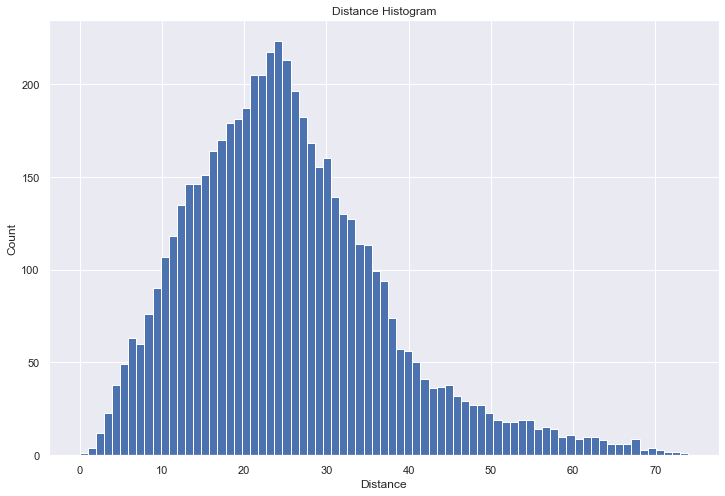

In [65]:
# find all the distances from a word to all other words, and the max distance
def get_distances(graph, start):
    visited = set()
    distances = {start: 0}
    queue = deque([start])
    max = 0
    while queue:
        word = queue.popleft()
        if word not in visited:
            visited.add(word)
            for neighbor in graph[word]:
                if neighbor not in visited:
                    queue.append(neighbor)
                    distances[neighbor] = distances[word] + 1
                    if distances[neighbor] > max:
                        max = distances[neighbor]
                        max_word = neighbor
    return distances, max, max_word

distances, max, max_word = get_distances(graph, 'AIDE')

# plot distances in a histogram
sns.set()

def plot_distances(graph, start):
    distances, max, max_word = get_distances(graph, start)
    values = np.array(list(distances.values()))
    plt.figure(figsize=(12, 8))
    plt.hist(values, bins=max)
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Distance Histogram')
    plt.show()

plot_distances(graph, 'AIDE')

In [92]:
# Step 1: Open the source text file in read mode
with open('wordsdetail.txt', 'r') as infile:
    # Step 2: Read the content of the file
    content = infile.read()

# Step 3: Split the content by whitespace to get a list of words
words = content.split()

# Step 4: Open a new text file in write mode
with open('wordsdetail2.txt', 'w') as outfile:
    # Step 5: Iterate through the list of words,
    # writing each word to a new line in the new file
    for word in words:
        outfile.write(word.upper() + '\n')

# Step 6: Both files are closed automatically by the 'with' statement


In [6]:
# Write a function that will calculate how many shortests paths there are from a word to another word and return all the paths
def get_num_shortest_paths(graph, start, end):
    visited = set()
    paths = []
    queue = deque([(start, [start])])  # Each element in the queue is a tuple (current_word, path_so_far)

    while queue:
        current_word, path = queue.popleft()

        # If the current word is the end word, we've found a path
        if current_word == end:
            paths.append(path)

        # Mark the current word as visited
        visited.add(current_word)

        # Add all neighboring words to the queue, if they haven't been visited yet
        for neighbor in graph[current_word]:
            if neighbor not in visited:
                queue.append((neighbor, path + [neighbor]))

    # If we reach here, it means there's no path from start to end
    return paths

# Test the function
graph = load_graph('wordsdetail_graph.pkl')
start_word = 'ROAN'
end_word = 'RUES'
num_shortest_paths = get_num_shortest_paths(graph, start_word, end_word)
num_shortest_paths

[['ROAN', 'ROAD', 'READ', 'REED', 'REES', 'RUES'],
 ['ROAN', 'ROAD', 'READ', 'REED', 'RUED', 'RUES'],
 ['ROAN', 'KOAN', 'KOAS', 'GOAS', 'GOES', 'ROES', 'RUES'],
 ['ROAN', 'KOAN', 'KOAS', 'KAAS', 'KAES', 'KUES', 'RUES'],
 ['ROAN', 'KOAN', 'KOAS', 'KEAS', 'KAES', 'KUES', 'RUES'],
 ['ROAN', 'KOAN', 'KOAS', 'KOBS', 'ROBS', 'ROES', 'RUES'],
 ['ROAN', 'KOAN', 'KOAS', 'KOBS', 'ROBS', 'RUBS', 'RUES'],
 ['ROAN', 'LOAN', 'LEAN', 'LEAS', 'LEES', 'LUES', 'RUES'],
 ['ROAN', 'LOAN', 'LEAN', 'LEAS', 'LEES', 'REES', 'RUES'],
 ['ROAN', 'LOAN', 'LORN', 'LORE', 'LURE', 'SURE', 'RUES'],
 ['ROAN', 'LOAN', 'LORN', 'LORE', 'SORE', 'ROES', 'RUES'],
 ['ROAN', 'LOAN', 'LORN', 'LORE', 'SORE', 'SURE', 'RUES'],
 ['ROAN', 'LOAN', 'LORN', 'SORN', 'SORE', 'ROES', 'RUES'],
 ['ROAN', 'LOAN', 'LORN', 'SORN', 'SORE', 'SURE', 'RUES'],
 ['ROAN', 'LOAN', 'LOWN', 'LOWS', 'ROWS', 'ROES', 'RUES'],
 ['ROAN', 'ROAD', 'GOAD', 'GOAS', 'GOES', 'ROES', 'RUES'],
 ['ROAN', 'ROAD', 'READ', 'DARE', 'DURE', 'RUED', 'RUES'],
 ['ROAN', 'RO